# `multidms` fitting pipeline

Here, we demonstrate the pipeline for fitting a `multidms` model on some data using the tools available in the package. Currently, we show how to pre-process data from various dms experiments targeting Delta and Omicron spike protein homologs.

In [5]:
# built-in libraries
import os
import sys
from itertools import combinations
from collections import defaultdict
import time

# external dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as onp
from tqdm.notebook import tqdm
import jax.numpy as jnp

import multidms
%load_ext autoreload
%autoreload 2
%matplotlib inline

**First, we'll define a few global variables.**

**Read in the dms data and list all available experimental conditions**

In [6]:
func_score_data = pd.DataFrame()
sites = {}
wt_seqs = {}

for homolog in ["Delta", "Omicron_BA.1", "Omicron_BA.2"]:
    
    # functional scores
    func_sel = pd.read_csv(f"../results/{homolog}/functional_selections.csv")
    func_sel = func_sel.assign(
        filename = f"../results/{homolog}/" + 
        func_sel.library + "_" + 
        func_sel.preselection_sample + 
        "_vs_" + func_sel.postselection_sample + 
        "_func_scores.csv"
    )
    func_sel = func_sel.assign(
        func_sel_scores_df = func_sel.filename.apply(lambda f: pd.read_csv(f))
    )
    func_sel = func_sel.assign(
        len_func_sel_scores_df = func_sel.func_sel_scores_df.apply(lambda x: len(x))
    )
    fun_sel = func_sel.assign(homolog = homolog)
    func_score_data = pd.concat([func_score_data, fun_sel]).reset_index(drop=True)

# Add a column that gives a unique ID to each homolog/DMS experiment
func_score_data['condition'] = func_score_data.apply(
    lambda row: f"{row['homolog']}-{row['library']}".replace('-Lib',''),
#     lambda row: f"{row['homolog']}-{row['library']}-{row['replicate']}".replace('-Lib',''),
    axis=1
)
func_score_data

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,condition
0,2021-10-28_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1,Lib-1_2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1
1,2021-10-28_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2,Lib-1_2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1
2,2021-10-28_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1,Lib-3_2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3
3,2021-10-28_thaw-1_VSVG_control_2,Lib-3,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2,Lib-3_2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3
4,2021-10-28_thaw-1_VSVG_control_1,Lib-4,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1,Lib-4_2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4
5,2021-10-28_thaw-1_VSVG_control_2,Lib-4,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2,Lib-4_2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4
6,2021-10-28_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1,Lib-2_2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2
7,2021-10-28_thaw-1_VSVG_control_2,Lib-2,thaw-1,2,2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2,Lib-2_2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2
8,2022-03-25_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1,Lib-1_2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1
9,2022-03-25_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2,Lib-1_2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1


**Define all the knobs which define the pipeline's pre-preprocessing behavior**

In [159]:
prep_params = {
    # pre-processing params
    "scale_counts" : False,
    "min_pre_counts" : 100,
    "pseudocount" : 0.1,
    "sample" : False, #5000,
    "min_pre_counts" : 100,
    "clip_target" : (-3.5, 2.5),
    "trim" : False,
    "reference_condition" : "Omicron_BA.2-1",
    "conditions" : ( #["Delta-3"] #( # ["Delta-3-1"] #(
#         "Delta-2", "Delta-3"#, #,
#         "Omicron_BA.1-2", "Omicron_BA.1-3" #,
        "Omicron_BA.2-1", "Omicron_BA.2-2"
    )
}

In [160]:
# uncomment to reset or if first time running notebook
# datasets = pd.DataFrame(columns=list(prep_params.keys()) + ["data"])

In [161]:
# datasets.loc[7, "conditions"]

## Pre-Proccessing

**Query the conditions to be included in a fit**

In [162]:
func_score_data_sub = func_score_data.query(
    f"condition.isin({list(prep_params['conditions'])})"
)
func_score_data_sub

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,condition
12,2022-10-22_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2022-10-22_thaw-1_no-antibody_control_1,Lib-1_2022-10-22_thaw-1_VSVG_control_1,Lib-1_2022-10-22_thaw-1_no-antibody_control_1,Lib-1_2022-10-22_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.2/Lib-1_2022-10-22_thaw-...,library pre_sampl...,90992,Omicron_BA.2,Omicron_BA.2-1
13,2022-10-22_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2022-10-22_thaw-1_no-antibody_control_1,Lib-2_2022-10-22_thaw-1_VSVG_control_1,Lib-2_2022-10-22_thaw-1_no-antibody_control_1,Lib-2_2022-10-22_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.2/Lib-2_2022-10-22_thaw-...,library pre_sampl...,85210,Omicron_BA.2,Omicron_BA.2-2
14,2022-10-22_thaw-2_VSVG_control_1,Lib-1,thaw-2,2,2022-10-22_thaw-2_no-antibody_control_1,Lib-1_2022-10-22_thaw-2_VSVG_control_1,Lib-1_2022-10-22_thaw-2_no-antibody_control_1,Lib-1_2022-10-22_thaw-2_VSVG_control_1_vs_2022...,../results/Omicron_BA.2/Lib-1_2022-10-22_thaw-...,library pre_sampl...,90992,Omicron_BA.2,Omicron_BA.2-1
15,2022-10-22_thaw-2_VSVG_control_1,Lib-2,thaw-2,2,2022-10-22_thaw-2_no-antibody_control_1,Lib-2_2022-10-22_thaw-2_VSVG_control_1,Lib-2_2022-10-22_thaw-2_no-antibody_control_1,Lib-2_2022-10-22_thaw-2_VSVG_control_1_vs_2022...,../results/Omicron_BA.2/Lib-2_2022-10-22_thaw-...,library pre_sampl...,85210,Omicron_BA.2,Omicron_BA.2-2


In [163]:
func_score_df = pd.DataFrame()
for idx, row in tqdm(func_score_data_sub.iterrows(), total=len(func_score_data_sub)):
    df = row.func_sel_scores_df.assign(homolog=row.homolog)
    df = df.assign(library = row.library)
    df = df.assign(replicate = row.replicate)
    exp_func_score_df = df.assign(condition=row.condition)
    func_score_df = pd.concat([func_score_df, exp_func_score_df])
func_score_df.rename({"aa_substitutions_reference":"aa_substitutions"}, axis=1, inplace=True)
func_score_df.head()

  0%|          | 0/4 [00:00<?, ?it/s]

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_codon_substitutions,aa_substitutions_sequential,n_aa_substitutions,aa_substitutions,pre_count_threshold,homolog,replicate,condition
0,Lib-1,2022-10-22_thaw-1_VSVG_control_1,2022-10-22_thaw-1_no-antibody_control_1,TACGGCGAAAATAGGA,-0.0480,0.0002,16987,17621,7350522,7882877,0.5,4,S936L H1085Y V1130A E1185D,4,S939L H1088Y V1133A E1188D,59,Omicron_BA.2,1,Omicron_BA.2-1
1,Lib-1,2022-10-22_thaw-1_VSVG_control_1,2022-10-22_thaw-1_no-antibody_control_1,CGAAACTCATTTATCC,-0.0121,0.0003,12987,13811,7350522,7882877,0.5,1,D50N,1,D53N,59,Omicron_BA.2,1,Omicron_BA.2-1
2,Lib-1,2022-10-22_thaw-1_VSVG_control_1,2022-10-22_thaw-1_no-antibody_control_1,GATTCTAACCTGATAC,-1.2233,0.0006,11071,5085,7350522,7882877,0.5,2,Q850R,1,Q853R,59,Omicron_BA.2,1,Omicron_BA.2-1
3,Lib-1,2022-10-22_thaw-1_VSVG_control_1,2022-10-22_thaw-1_no-antibody_control_1,CAAGCTTTAAAATACC,0.0821,0.0004,10277,11667,7350522,7882877,0.5,1,S95N,1,S98N,59,Omicron_BA.2,1,Omicron_BA.2-1
4,Lib-1,2022-10-22_thaw-1_VSVG_control_1,2022-10-22_thaw-1_no-antibody_control_1,CAAAAGTCAAATAAAC,-1.8112,0.0010,9092,2778,7350522,7882877,0.5,1,A843S,1,A846S,59,Omicron_BA.2,1,Omicron_BA.2-1


**Optionally subset the variants**

In [164]:
if prep_params["sample"]:
    func_score_df = func_score_df.sample(prep_params["sample"])

**remove all variants with string sites and stop codon wildtypes**

In [165]:
func_score_df.aa_substitutions.fillna("", inplace=True)
gapped_sub_vars = []
stop_wt_vars = []
non_numeric_sites = []
for idx, row in tqdm(func_score_df.iterrows(), total=len(func_score_df)):
    if "-" in row["aa_substitutions"]:
        gapped_sub_vars.append(idx)
    for sub in row["aa_substitutions"].split():
        if sub[0] == "*":
            stop_wt_vars.append(idx)
        if not sub[-2].isnumeric():
            non_numeric_sites.append(idx)

to_drop = set.union(set(gapped_sub_vars), set(stop_wt_vars), set(non_numeric_sites))
func_score_df.drop(to_drop, inplace=True)

  0%|          | 0/352404 [00:00<?, ?it/s]

**Drop all variants with pre-counts below a threshold.**

In [166]:
# Drop barcoded variants with pre-counts below a threshold
n_pre_threshold = len(func_score_df)
func_score_df = func_score_df[func_score_df['pre_count'] >= prep_params["min_pre_counts"]]
print(f"Of {n_pre_threshold} variants, {n_pre_threshold - len(func_score_df)} had fewer than {prep_params['min_pre_counts']} counts before selection, and were filtered out")

Of 329336 variants, 41439 had fewer than 100 counts before selection, and were filtered out


**Optionally, scale the counts**

In [167]:
if prep_params['scale_counts']:
    func_score_df = multidms.utils.scale_func_score(func_score_df)

In [168]:
func_score_df.func_score.describe()

count    287897.000000
mean         -1.855043
std           2.718713
min         -13.105700
25%          -2.601100
50%          -0.877400
75%          -0.070700
max           4.011800
Name: func_score, dtype: float64

**Optionally, clip the target functional scores**

In [169]:
if prep_params['clip_target'] and prep_params['trim']:
    l,h = prep_params['clip_target']
    func_score_trim = func_score_df.query(
        f"(func_score >= {l}) & (func_score <= {h})"
    )
    diff = len(func_score_df) - len(func_score_trim)
    print(f"Of {len(func_score_df)} variants, {diff} were thrown during trimming")
    func_score_df = func_score_trim

In [170]:
if prep_params['clip_target'] and not prep_params['trim']:
    func_score_df['func_score'] = func_score_df['func_score'].clip(*prep_params['clip_target'])

## `MultiDmsData`

In [171]:
# uncomment to see docs
# help(multidms.MultiDmsData)
# unscaled_data = data

In [172]:
data = multidms.MultiDmsData(
    func_score_df,
    alphabet= multidms.AAS_WITHSTOP,
    condition_colors = sns.color_palette("Paired"),
    reference=prep_params['reference_condition']
)

100%|███████████████████████████████████████████████████████████████████████████████████| 56000/56000 [02:04<00:00, 448.19it/s]


In [173]:
data_row = pd.Series(prep_params).to_frame().T
data_row['data'] = data
datasets = pd.concat([datasets, data_row], ignore_index=True)
datasets

,scale_counts,min_pre_counts,pseudocount,sample,clip_target,trim,reference_condition,conditions,data
0,False,100,0.1,False,"(-3.5, 2.5)",False,Delta-2,"(Delta-2, Delta-3, Omicron_BA.1-2, Omicron_BA....",<multidms.data.MultiDmsData object at 0x7f21e1...
1,False,100,0.1,False,"(-3.5, 2.5)",False,Omicron_BA.1-2,"(Delta-2, Delta-3, Omicron_BA.1-2, Omicron_BA....",<multidms.data.MultiDmsData object at 0x7f21b9...
2,False,100,0.1,False,"(-3.5, 2.5)",False,Omicron_BA.2-1,"(Delta-2, Delta-3, Omicron_BA.1-2, Omicron_BA....",<multidms.data.MultiDmsData object at 0x7f21b9...
3,False,100,0.1,False,"(-3.5, 2.5)",False,Delta-2,[Delta-2],<multidms.data.MultiDmsData object at 0x7f21d7...
4,False,100,0.1,False,"(-3.5, 2.5)",False,Delta-3,[Delta-3],<multidms.data.MultiDmsData object at 0x7f21b9...
5,False,100,0.1,False,"(-3.5, 2.5)",False,Delta-2,"(Delta-2, Delta-3)",<multidms.data.MultiDmsData object at 0x7f21d7...
6,False,100,0.1,False,"(-3.5, 2.5)",False,Omicron_BA.1-2,"(Omicron_BA.1-2, Omicron_BA.1-3)",<multidms.data.MultiDmsData object at 0x7f21d6...
7,False,100,0.1,False,"(-3.5, 2.5)",False,Omicron_BA.2-1,"(Omicron_BA.2-1, Omicron_BA.2-2)",<multidms.data.MultiDmsData object at 0x7f21d0...


In [174]:
list(datasets["conditions"][0])

['Delta-2',
 'Delta-3',
 'Omicron_BA.1-2',
 'Omicron_BA.1-3',
 'Omicron_BA.2-1',
 'Omicron_BA.2-2']

In [175]:
a_data_object = datasets.loc[0, "data"]

In [176]:
a_data_object.site_map.head()

,Delta-2,Delta-3,Omicron_BA.1-2,Omicron_BA.1-3,Omicron_BA.2-1,Omicron_BA.2-2
1015,A,A,A,A,A,A
1188,E,E,E,E,E,E
1027,T,T,T,T,T,T
1016,A,A,A,A,A,A
1091,R,R,R,R,R,R


In [177]:
a_data_object.mutations[:5]

('M1F', 'M1I', 'M1K', 'M1L', 'M1N')

In [142]:
a_data_object.mutations_df.head()

,mutation,wts,sites,muts,times_seen_Delta-2,times_seen_Delta-3,times_seen_Omicron_BA.1-2,times_seen_Omicron_BA.1-3,times_seen_Omicron_BA.2-1,times_seen_Omicron_BA.2-2
0,M1F,M,1,F,1.0,9.0,0.0,0.0,0.0,0.0
1,M1I,M,1,I,2.0,8.0,4.0,6.0,6.0,7.0
2,M1K,M,1,K,3.0,5.0,0.0,0.0,0.0,0.0
3,M1L,M,1,L,3.0,3.0,0.0,0.0,0.0,1.0
4,M1N,M,1,N,0.0,4.0,0.0,0.0,0.0,0.0


In [749]:
a_data_object.conditions

('Omicron_BA.1-2-1', 'Omicron_BA.1-3-1')

In [750]:
a_data_object.reference

'Omicron_BA.1-2-1'

In [751]:
a_data_object.binarymaps # this is poorly named, 'y' also exists here

{'Omicron_BA.1-2-1': <binarymap.binarymap.BinaryMap at 0x7fdf6c220190>,
 'Omicron_BA.1-3-1': <binarymap.binarymap.BinaryMap at 0x7fdf6c26ee60>}

In [752]:
a_data_object.non_identical_sites

frozendict.frozendict({'Omicron_BA.1-2-1': [], 'Omicron_BA.1-3-1': array([], dtype=int64)})

In [753]:
a_data_object.non_identical_mutations

frozendict.frozendict({'Omicron_BA.1-2-1': '', 'Omicron_BA.1-3-1': ''})

**We can run the compiled functions diretly, as well**

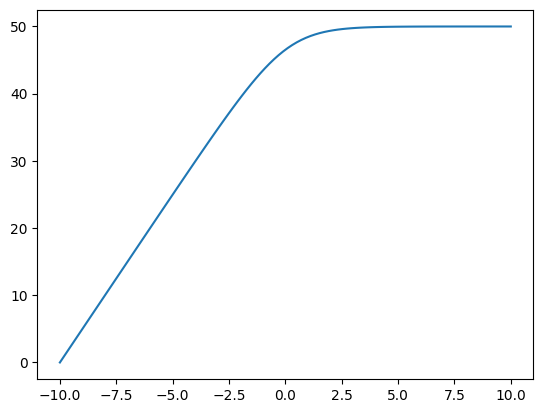

In [754]:

import multidms.model
x = jnp.array(onp.linspace(-10, 10, 100))
custom_params = {"ge_scale":jnp.array([5]) , "ge_bias":jnp.array([50])}
y = multidms.model.softplus_global_epistasis(custom_params, x)
plt.plot(x, y)
plt.show()

In [756]:
datasets

,scale_counts,min_pre_counts,pseudocount,sample,clip_target,trim,reference_condition,conditions,data
0,False,100,0.1,False,"(-3.5, 2.5)",False,Omicron_BA.1-2-1,"(Omicron_BA.1-2-1, Omicron_BA.1-3-1)",<multidms.data.MultiDmsData object at 0x7fdd0a...
1,False,100,0.1,False,"(-3.5, 2.5)",False,Delta-2-1,"(Delta-2-1, Delta-3-1)",<multidms.data.MultiDmsData object at 0x7fdd0a...
2,False,100,0.1,False,"(-3.5, 2.5)",False,Omicron_BA.2-1-1,"(Omicron_BA.2-1-1, Omicron_BA.2-2-1)",<multidms.data.MultiDmsData object at 0x7fdcc9...
3,False,100,0.1,False,"(-3.5, 2.5)",False,Delta-2-1,[Delta-2-1],<multidms.data.MultiDmsData object at 0x7fdcc8...
4,False,100,0.1,False,"(-3.5, 2.5)",False,Delta-3-1,[Delta-3-1],<multidms.data.MultiDmsData object at 0x7fdcd4...
5,False,100,0.1,False,"(-3.5, 2.5)",False,Delta-2-1,"(Delta-2-1, Delta-3-1, Omicron_BA.1-2-1, Omicr...",<multidms.data.MultiDmsData object at 0x7fdcd5...
6,False,100,0.1,False,"(-3.5, 2.5)",False,Omicron_BA.1-2-1,"(Delta-2-1, Delta-3-1, Omicron_BA.1-2-1, Omicr...",<multidms.data.MultiDmsData object at 0x7fdcd6...
7,False,100,0.1,False,"(-3.5, 2.5)",False,Omicron_BA.1-2,"(Delta-2, Delta-3, Omicron_BA.1-2, Omicron_BA....",<multidms.data.MultiDmsData object at 0x7fdc2a...
8,False,100,0.1,False,"(-3.5, 2.5)",False,Delta-2,"(Delta-2, Delta-3, Omicron_BA.1-2, Omicron_BA....",<multidms.data.MultiDmsData object at 0x7fdaeb...
9,False,100,0.1,False,"(-3.5, 2.5)",False,Omicron_BA.2-1,"(Delta-2, Delta-3, Omicron_BA.1-2, Omicron_BA....",<multidms.data.MultiDmsData object at 0x7fdaeb...


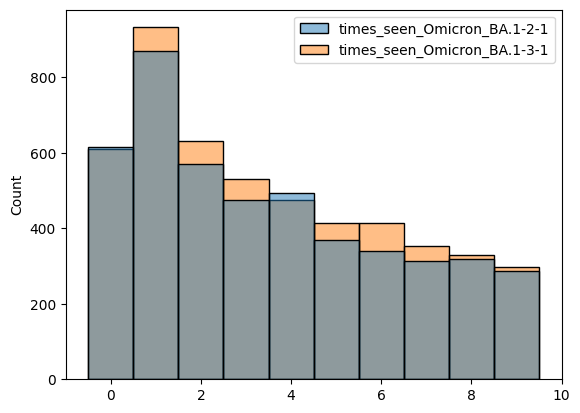

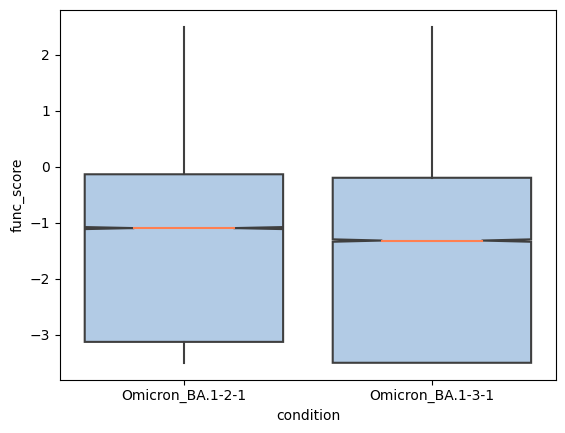

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='condition', ylabel='func_score'>)

In [757]:
doi = datasets.loc[0, "data"]
bins = onp.arange(-0.5, 10, 1)
doi.plot_times_seen_hist(bins=bins)
doi.plot_func_score_boxplot()

## `MultiDmsModel`

**To fit a mopdel, we first choose a dataset(s) we would like to fit**

In [179]:
datasets

,scale_counts,min_pre_counts,pseudocount,sample,clip_target,trim,reference_condition,conditions,data
0,False,100,0.1,False,"(-3.5, 2.5)",False,Delta-2,"(Delta-2, Delta-3, Omicron_BA.1-2, Omicron_BA....",<multidms.data.MultiDmsData object at 0x7f21e1...
1,False,100,0.1,False,"(-3.5, 2.5)",False,Omicron_BA.1-2,"(Delta-2, Delta-3, Omicron_BA.1-2, Omicron_BA....",<multidms.data.MultiDmsData object at 0x7f21b9...
2,False,100,0.1,False,"(-3.5, 2.5)",False,Omicron_BA.2-1,"(Delta-2, Delta-3, Omicron_BA.1-2, Omicron_BA....",<multidms.data.MultiDmsData object at 0x7f21b9...
3,False,100,0.1,False,"(-3.5, 2.5)",False,Delta-2,[Delta-2],<multidms.data.MultiDmsData object at 0x7f21d7...
4,False,100,0.1,False,"(-3.5, 2.5)",False,Delta-3,[Delta-3],<multidms.data.MultiDmsData object at 0x7f21b9...
5,False,100,0.1,False,"(-3.5, 2.5)",False,Delta-2,"(Delta-2, Delta-3)",<multidms.data.MultiDmsData object at 0x7f21d7...
6,False,100,0.1,False,"(-3.5, 2.5)",False,Omicron_BA.1-2,"(Omicron_BA.1-2, Omicron_BA.1-3)",<multidms.data.MultiDmsData object at 0x7f21d6...
7,False,100,0.1,False,"(-3.5, 2.5)",False,Omicron_BA.2-1,"(Omicron_BA.2-1, Omicron_BA.2-2)",<multidms.data.MultiDmsData object at 0x7f21d0...


In [59]:
# un-comment to re-initialize results
# models = defaultdict(list)

**Next, we iterate through datasets, and models of interest then; initialize a model object with the respective dataset, then fit that data to a model with some given hyperparameters. Finally, save the models in a dataframe for plotting.**

In [180]:
for dataset in range(3,8):
    for ge_func in ["sigmoid", "softplus", "identity"]:
        for output_act in ["softplus"]:
            
            imodel = multidms.MultiDmsModel(
                    datasets.loc[dataset, 'data'],
                    latent_model="phi",
                    epistatic_model=ge_func,
                    output_activation=output_act
            )
            
            start = time.time()
            imodel.fit(lasso_shift=1e-5, maxiter=5000, tol=1e-6)
            end = time.time()
            print(f"{ge_func},{output_act} done. fitting time = {end - start}")
            
            models["ge_func"].append(ge_func)
            models["output_act"].append(output_act)
            models["model"].append(imodel)
            models["dataset"].append(dataset)
            
models_df = pd.DataFrame(models)
models_df.tail(20)

sigmoid,softplus done. fitting time = 12.035218238830566
softplus,softplus done. fitting time = 11.82287311553955
identity,softplus done. fitting time = 11.100468873977661
sigmoid,softplus done. fitting time = 12.188494682312012
softplus,softplus done. fitting time = 11.586337566375732
identity,softplus done. fitting time = 11.269272327423096
sigmoid,softplus done. fitting time = 20.254647731781006
softplus,softplus done. fitting time = 19.827967882156372
identity,softplus done. fitting time = 19.568926334381104
sigmoid,softplus done. fitting time = 24.274688005447388
softplus,softplus done. fitting time = 23.579418897628784
identity,softplus done. fitting time = 22.92071533203125
sigmoid,softplus done. fitting time = 23.86466693878174
softplus,softplus done. fitting time = 23.367626667022705
identity,softplus done. fitting time = 23.03555703163147


,ge_func,output_act,model,dataset
4,softplus,softplus,<multidms.model.MultiDmsModel object at 0x7f21...,1
5,identity,softplus,<multidms.model.MultiDmsModel object at 0x7f21...,1
6,sigmoid,softplus,<multidms.model.MultiDmsModel object at 0x7f21...,2
7,softplus,softplus,<multidms.model.MultiDmsModel object at 0x7f21...,2
8,identity,softplus,<multidms.model.MultiDmsModel object at 0x7f21...,2
9,sigmoid,softplus,<multidms.model.MultiDmsModel object at 0x7f21...,3
10,softplus,softplus,<multidms.model.MultiDmsModel object at 0x7f21...,3
11,identity,softplus,<multidms.model.MultiDmsModel object at 0x7f21...,3
12,sigmoid,softplus,<multidms.model.MultiDmsModel object at 0x7f21...,4
13,softplus,softplus,<multidms.model.MultiDmsModel object at 0x7f21...,4


In [282]:
a_model_object = models_df.loc[0, "model"]
a_model_object

**models with the same dataset share the reference. This saves precious memory.**

In [283]:
model_w_same_dataset = models_df.loc[1, "model"]
model_w_same_dataset.data is a_model_object.data

True

**The Model object shares many similar properties from the data object, like mutations and variants dataframes, but the getters give you useful model-specific features like parameters and predictios.**

In [287]:
a_model_object.mutations_df

,mutation,wts,sites,muts,times_seen_Delta-2,times_seen_Delta-3,times_seen_Omicron_BA.1-2,times_seen_Omicron_BA.1-3,times_seen_Omicron_BA.2-1,times_seen_Omicron_BA.2-2,...,S_Delta-2,F_Delta-2,S_Omicron_BA.1-2,F_Omicron_BA.1-2,S_Omicron_BA.1-3,F_Omicron_BA.1-3,S_Omicron_BA.2-1,F_Omicron_BA.2-1,S_Omicron_BA.2-2,F_Omicron_BA.2-2
0,M1F,M,1,F,1.0,9.0,0.0,0.0,0.0,0.0,...,0.0,-1.123650,0.000000,-1.123650,0.000000,-1.123650,0.000000,-1.123650,0.000000,-1.123650
1,M1I,M,1,I,2.0,8.0,4.0,6.0,6.0,7.0,...,0.0,-2.569728,-0.000037,-2.569784,0.006811,-2.561211,-0.003851,-2.574558,0.072682,-2.478590
2,M1K,M,1,K,3.0,5.0,0.0,0.0,0.0,0.0,...,0.0,-1.626889,0.000000,-1.626889,0.000000,-1.626889,0.000000,-1.626889,0.000000,-1.626889
3,M1L,M,1,L,3.0,3.0,0.0,0.0,0.0,1.0,...,0.0,-3.499982,0.000000,-4.352419,0.000000,-4.333765,0.000000,-4.360919,0.017540,-4.351978
4,M1N,M,1,N,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,-0.080572,0.000000,-0.080572,0.000000,-0.080572,0.000000,-0.080572,0.000000,-0.080572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10630,S1252T,S,1252,T,19.0,30.0,105.0,77.0,86.0,78.0,...,0.0,-0.150053,0.196885,-0.106962,0.110413,-0.124942,0.027921,-0.143464,0.078992,-0.131835
10631,S1252V,S,1252,V,11.0,16.0,66.0,46.0,60.0,60.0,...,0.0,0.031790,-0.429765,-0.004842,-0.404693,-0.002264,-0.782910,-0.048535,-0.780753,-0.048221
10632,S1252W,S,1252,W,2.0,5.0,21.0,26.0,24.0,27.0,...,0.0,-0.016703,-0.040622,-0.021483,0.138632,-0.001716,-0.035187,-0.020833,0.069268,-0.008966
10633,S1252Y,S,1252,Y,30.0,29.0,78.0,71.0,118.0,141.0,...,0.0,0.048225,-0.413030,0.021418,-0.167782,0.038616,-0.556565,0.009285,-0.604412,0.004853


In [288]:
a_model_object.variants_df

,condition,aa_substitutions,weight,func_score,var_wrt_ref,predicted_latent,predicted_func_score,corrected_func_score
0,Delta-2,,6660,-0.139009,,3.337947,-0.070888,-0.139009
1,Delta-2,A1015D,2,-1.737700,A1015D,-1.151349,-3.489260,-1.737700
2,Delta-2,A1015D E1188Q,2,-1.641850,A1015D E1188Q,-1.255876,-3.495636,-1.641850
3,Delta-2,A1015D T1027S,1,-3.500000,A1015D T1027S,-1.550191,-3.499573,-3.500000
4,Delta-2,A1016S,5,-0.120760,A1016S,3.192366,-0.096836,-0.120760
...,...,...,...,...,...,...,...,...
272258,Omicron_BA.2-2,Y91T K129N,2,-3.500000,H655Y E484A N440K N679K R681H T376A S477N N501...,-3.852895,-4.806900,-5.010247
272259,Omicron_BA.2-2,Y91T T553I,2,-3.375950,H655Y E484A N440K N679K R681H T376A S477N N501...,-4.290315,-4.837798,-4.886197
272260,Omicron_BA.2-2,Y91V A1078S,1,-1.466500,A1078S H655Y E484A N440K N679K R681H T376A S47...,-2.652859,-4.592986,-2.976747
272261,Omicron_BA.2-2,Y91V S112N M177K L335P N405A C671R K679R T859A...,1,-3.500000,M1237I H655Y E484A N440K N679R R681H T376A S47...,-8.216387,-4.888796,-5.010247


### Visualization

**The one mutable attribute of MultiDmsData objects is the condition_colors. We will set a custom color patte to be shared across datasets such that our multiple fit plots are consistant.**

In [213]:
colors = list(sns.color_palette("colorblind", 6))
conditions = datasets.loc[0, "data"].conditions
cc = {con:tuple(col) for con, col in zip(conditions, colors)}
for row, values in datasets.iterrows():
    values.data.condition_colors = cc

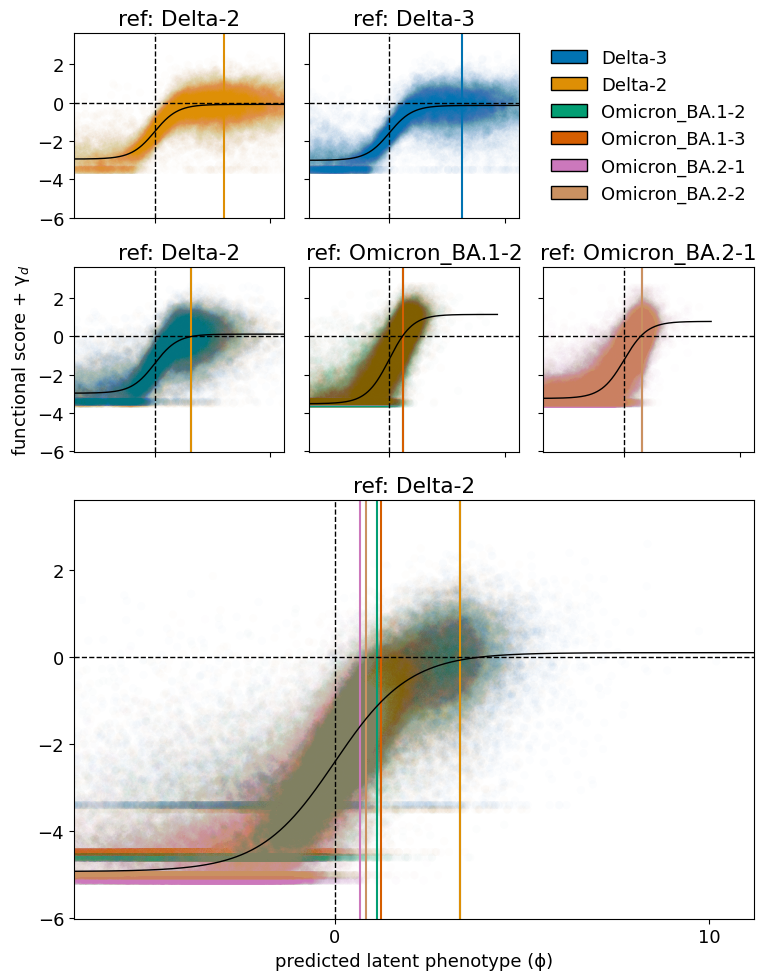

In [264]:
plt.rcParams.update({'font.size': 13})
fig = plt.figure(constrained_layout=True, figsize=(8,10))
axd = fig.subplot_mosaic(
    """
    abc
    def
    ggg
    ggg
    """,
    empty_sentinel="X",
    sharex=True,
    sharey=True,
)

model_ax_dict = {
    "a" : 9,
    "b" : 12,
    "d" : 15,
    "e" : 18,
    "f" : 21,
    "g" : 0
}

for axi, model in model_ax_dict.items():
    moi = models_df.loc[model, "model"]
    moi.plot_epistasis(show=False, legend=False, alpha=0.01, ax=axd[axi])
    axd[axi].set_title(f"ref: {moi.data.reference}")
axd["a"].set_ylabel("")
axd["g"].set_ylabel("")
axd["c"].axis('off')
legend_elements = [
    patches.Patch(
         facecolor=col, 
         edgecolor="black", 
         label=con
    )
    for con, col in cc.items()
]
axd["c"].legend(
        handles=legend_elements, 
        loc="center",
        frameon=False
)
plt.tight_layout()
fig.savefig("model-mixing.png")
plt.show()

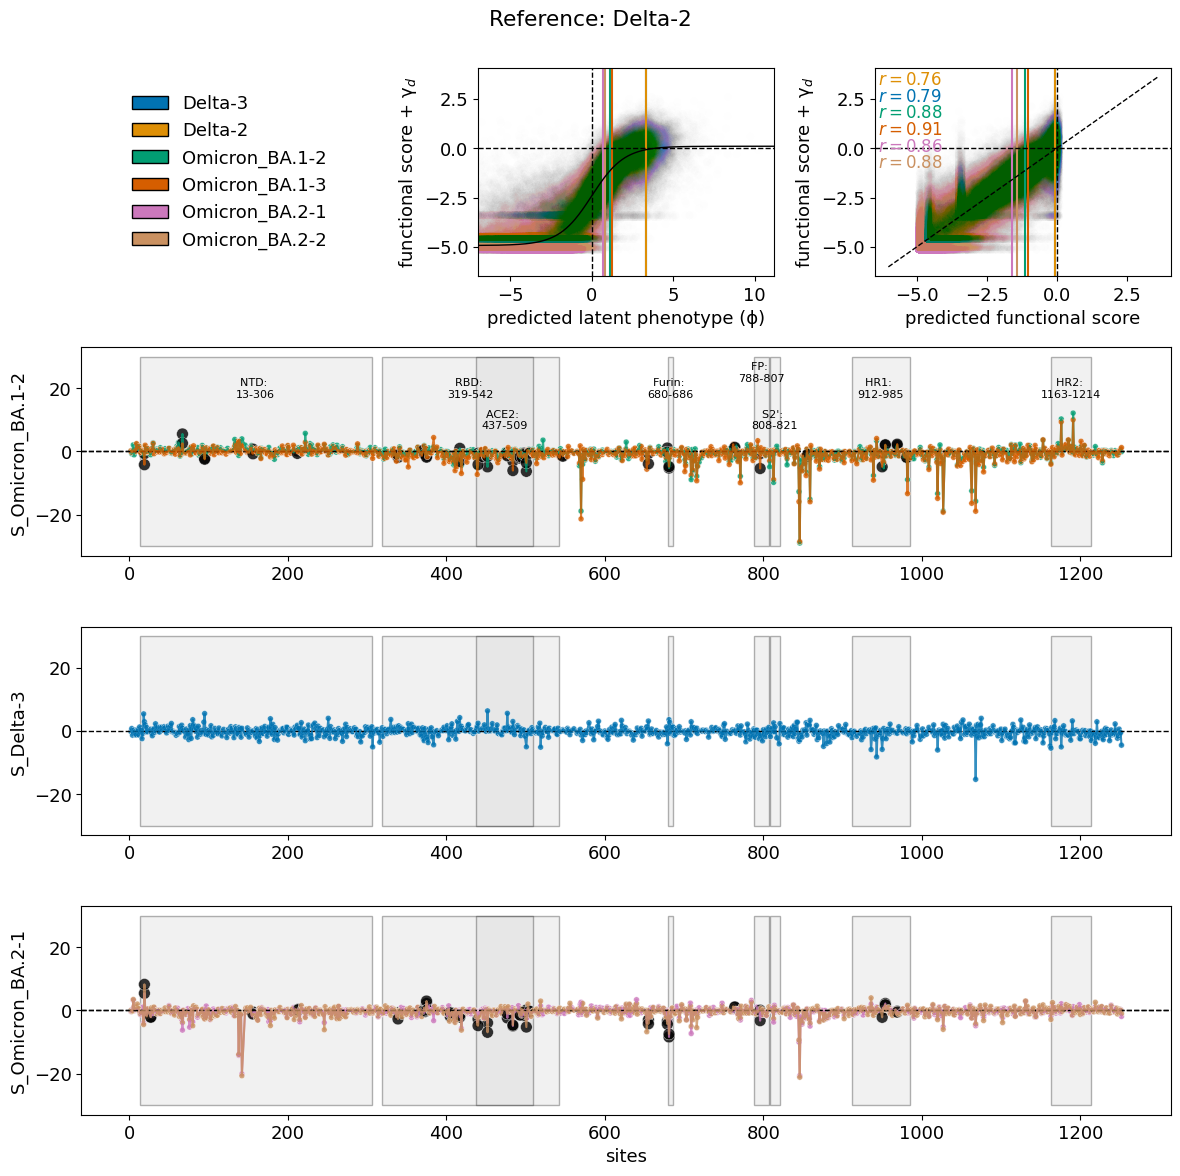

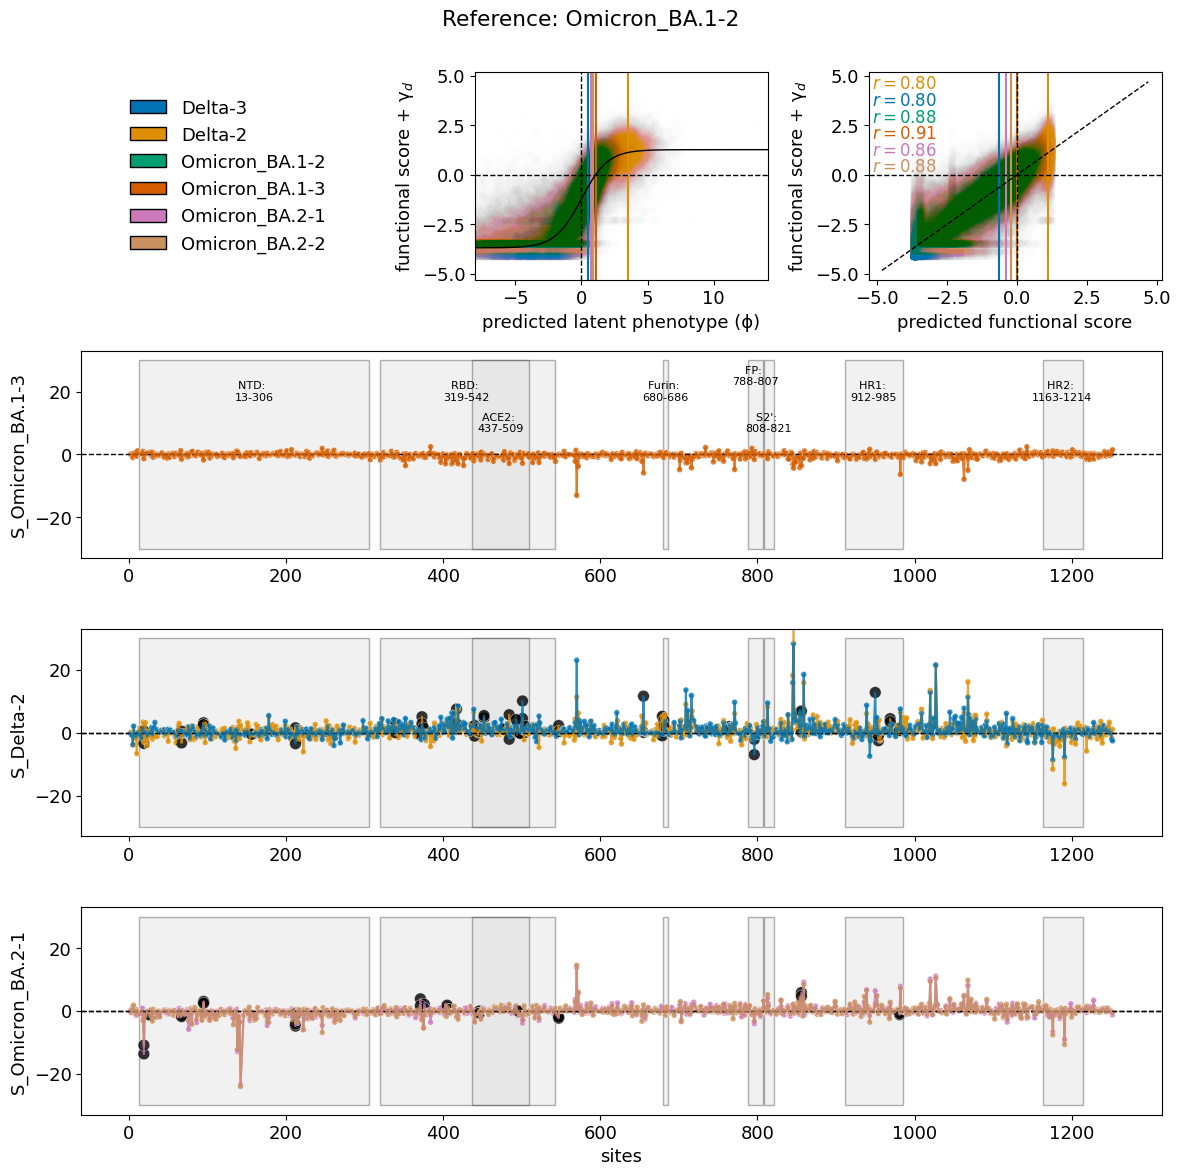

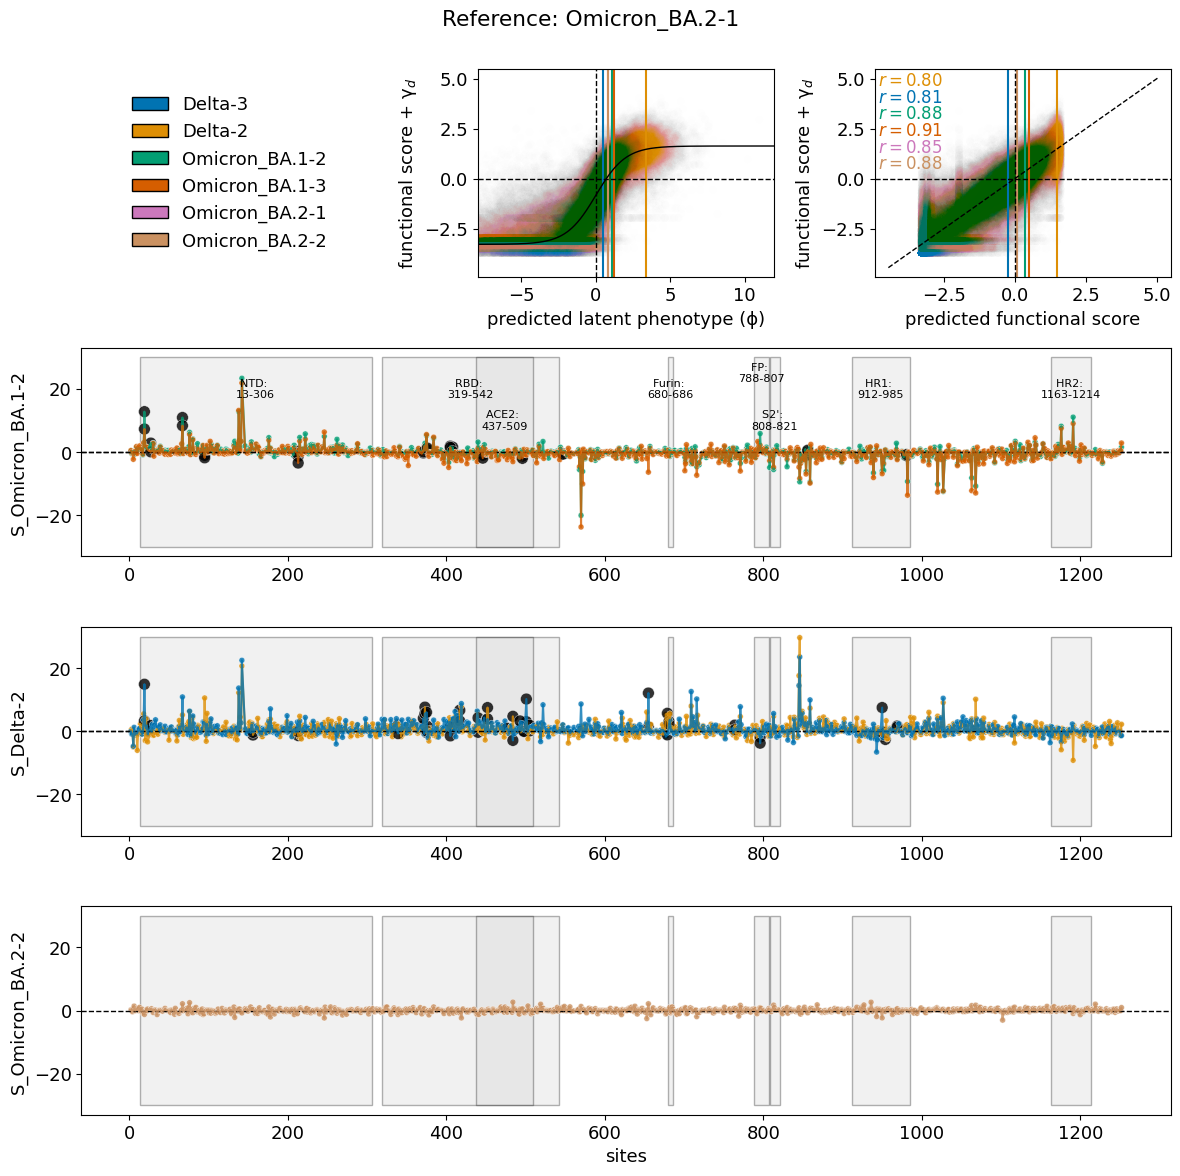

In [284]:
def sum_abs(x): 
    return sum([abs(t) for t in x if t == t])
def mean_abs(x): 
    return onp.mean([abs(t) for t in x if t == t])
def max_abs(x): 
    return onp.max([abs(t) for t in x if t == t])

for model in [0,3,6]:
    fig = plt.figure(constrained_layout=True, figsize=(12,12))
    axd = fig.subplot_mosaic(
        """
        ace
        bbb
        ddd
        fff
        """,
        empty_sentinel="X"
    )

    protein_regions = {
        "NTD" :  [13, 305],                                                 
        "RBD" : [319, 541],
        "ACE2" : [437, 508],
        "Furin" : [680, 685],
        "FP" : [788, 806],
        "S2'"  : [808, 820],
        "HR1" : [912, 984],
        "HR2" : [1163, 1213]
    }

    moi = models_df.loc[model, "model"]
    fig.suptitle(f"Reference: {moi.data.reference}\n")
    moi.plot_epistasis(show=False, legend=False, alpha=0.005, ax=axd["c"])
    moi.plot_pred_accuracy(show=False, legend=False, alpha=0.005, ax=axd["e"])

    facet_groups = {
        "b" : ("Omicron_BA.1-2", "Omicron_BA.1-3"),
        "d" : ("Delta-2", "Delta-3"),
        "f" : ("Omicron_BA.2-1", "Omicron_BA.2-2")
    }

    for axi, facet_group in facet_groups.items():

        for pr, data in protein_regions.items():

            start = data[0]
            end = data[1] + 1
            width = end - start
            middle = start + (width//2)

            rect_v = patches.Rectangle(
                    (start, -30),
                    width=width,
                    height=60,
                    clip_on=False,
                    linewidth=1,
                    edgecolor='black',
                    facecolor='lightgrey',
                    alpha=0.3
            )
            axd[axi].add_patch(rect_v)

        for condition in facet_group:
            
            if condition == moi.data.reference: continue
            moi.plot_shifts_by_site(
                condition,
                show=False, 
                agg_func=onp.sum,
                times_seen_threshold=3,
                ax=axd[axi],
                alpha=0.8
            )

    for pr, data in protein_regions.items():

        start = data[0]
        end = data[1] + 1
        width = end - start
        middle = start + (width//2)

        anno = f"{pr}: \n{start}-{end}"
        ycoord = 20
        if pr in ["ACE2", "S2'"]:
            ycoord = 10
        if pr in ["FP"]:
            ycoord = 25

        axd["b"].text(middle, ycoord, anno, va="center", ha="center", size=8, rotation=0)

    axd["a"].axis('off')
    legend_elements = [
        patches.Patch(
             facecolor=col, 
             edgecolor="black", 
             label=con
        )
        for con, col in cc.items()
    ]
    axd["a"].legend(
            handles=legend_elements, 
            loc="center",
            frameon=False
    )

    axd["b"].sharex(axd["f"])
    axd["b"].sharey(axd["f"])
    axd["b"].set_xlabel("")

    axd["d"].sharex(axd["f"])
    axd["d"].sharey(axd["f"])
    axd["d"].set_xlabel("")

    axd["c"].sharey(axd["e"])
    axd["d"].set_xlabel("")


    plt.tight_layout()
    plt.show()

    fig.savefig(f"reference_{moi.data.reference}.pdf")